In [15]:
import numpy as np
import pylab as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook

In [38]:
TAU_TWO = 0.3
TAU_FALL= 0.45
THRESHOLD= -30.0


CM  = 1.00  # /*uF/cm2*/
I_APP = 0.00 # /*uA/cm2*/

E_NA =  50.0
E_K  = -90.0
E_L  = -71.975 # //-70.4
E_SYN_SH =  -55.0 #reversal potential of GABA_Asynapse - determines shunt (-55) 
E_SYN_H =  -75.0 #reversal potential of GABA_Asynapse - determines hyperpolarizing (-75) 
E_SYN_AMPA = 0.0
#E_SYN =  -75.0 #reversal potential of GABA_Asynapse - determines shunt (-55) versus hyperpolarizing (-75) 

G_NA = 218.8 # //239.13  mS/cm2 all conductances were divided by 0.000096 cm2
G_K3 =  8.225 # // 10.22469
G_K1 =  0.769 # // 1.1058
G_L  = 0.1915 # // 0.2224

G_SYN =   0.0214844 #single synapse value is 0.02391 mS/cm2*/ 
G_SYN2 =  0.09115 # // equal to 7 nS ChR*/ channel rhodopsin conductance
G_SYN3 =  23*0.0214844 # // autapse single synapse value

#Below are the values with regard to EXCITATION
#G_SYN_AMPA is 0.5 in intensive units. IN the extensive, we have (0.5*0.02148)/1.65 = 0.01074/1.65 = 0.00650909 
G_AMPA = 0.00651041*2
G_SYN_AMPA = 100*G_AMPA

TAU_AMPA = 1.0

DELAY = 0.3

THETA_M = -52.995 # // -56.42
SIGMA1_M = 4.0
SIGMA2_M = -13.0
K1_M = 0.25
K2_M = 0.1

THETA_H = -55.711 # //-56.59
SIGMA1_H = -20.0
SIGMA2_H = 3.5
K1_H = 0.012
K2_H = 0.2

THETA_N = 5.9 # // -4.23
SIGMA1_N = 12.0
SIGMA2_N = -8.5
K1_N = 1.0 
K2_N = 0.001

THETA_A = 51.355 # // 51.4
SIGMA1_A = 12.0
SIGMA2_A = -80.0
K1_A = 1.0 
K2_A = 0.02

ALPHA = 6.25 # /* ms */
TAUSYN = 1.0 # /*  1.0 3.0 2.0   */
SS1 = 0.00
SS2 = 0.00
I_STIM = 0.0

In [39]:
#Defining some functions that are required for the routine

def boltz(V,half,slope): 
    arg = -(V-half)/slope
    if( (arg>50.0) or (arg<-50) ):
        if(arg>50):
            return(0.0)
        else:
            return(1.0)
    else:
        return(1.0/(1.0 + np.exp(arg)))

def gaussian(v,a,b,c,d):
    arg = ((v-c)/b)**2
    if( (arg>50.0) or (arg<-50) ):
        if(arg>50):
            return(d)
        else:
            return(d+a)
    else:
        return((d + a*np.exp(-arg)))

def efun(z):
    if(abs(z) < 1e-4):
        return(1 - z/2)
    else:
        return(z/(np.exp(z) - 1))
    
def alpha(v,k,theta,sigma):
    arg = (theta-v)/sigma
    if(v == theta):
        return(k*sigma)
    else:
        if( (arg>50.0) or (arg<-50) ):
            if(arg>50.0): 
                return(0.0)
            else:
                return(k*(v - theta))
        else:
            return(k*(theta-v)/(np.exp(arg) - 1.0))

def beta(v,k,sigma):
    return(k*np.exp(v/sigma))

#This function identifies the onset of a spike, the first time the threshold is crossed
def spike(x,t):
    'An event when V1 >= THRESHOLD'
    if (t == 0.0):
        return 0
    
    if (x[0] >= THRESHOLD):
        return 1
    else:
        return 0

In [40]:
#Functions for Synaptic Currents 
def I_NA(V, M, H): return G_NA * (M**3) * H * (V - E_NA)
def I_K1(V,A): return G_K1 * (A**4) * (V - E_K)
def I_L(V): return G_L * (V - E_L)
def I_K3(V,N): return G_K3 * (N**4) * (V - E_K)
def I_S1(V,gsyn1):   return gsyn1 * (V - E_SYN_AMPA)
def I_S2(V):   return G_SYN2 * V
def I_S3(V,G): return G * (V - E_SYN_SH)

In [41]:
def ODE_Routine(intitial_values,tf,h):
    e = [spike(initial_values[0],0)]
    h2 = h/2
    N = tf/h
    N = int(N)
    end = int(N)
    t = np.linspace(0,tf,N+1)
    Autapse_Times = []
    t_autapse = -1
    gsyn1 = 0

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))
    A = np.zeros(len(t))
    M = np.zeros(len(t))
    X = np.zeros(len(t))
    G = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    H[0] = initial_values[1]
    N[0] = initial_values[2]
    A[0] = initial_values[3]
    M[0] = initial_values[4]
    X[0] = initial_values[5]
    G[0] = initial_values[6]
    
    sol = [initial_values]
    
    for i in range(end):
        if(round(t[i],3) == round(t_autapse,3)):
        #if(t[i] == t_autapse):
            print(t[i],t_autapse)
            X[i] = X[i] + G_SYN3  
        
        k1V = (I_STIM - I_S2(V[i]) - I_NA(V[i],M[i],H[i]) - I_K1(V[i],A[i]) - I_K3(V[i],N[i]) - I_L(V[i]) - I_S1(V[i],gsyn1) - I_S3(V[i],G[i])) / CM
        k1H = beta(V[i],K1_H,SIGMA1_H)*(1.0 - H[i]) - alpha(V[i],K2_H,THETA_H,SIGMA2_H)*H[i]
        k1N = alpha(V[i],K1_N,THETA_N,SIGMA1_N)*(1.0 - N[i]) - beta(V[i],K2_N,SIGMA2_N)*N[i]
        k1A = alpha(V[i],K1_A,THETA_A,SIGMA1_A)*(1.0 - A[i]) - beta(V[i],K2_A,SIGMA2_A)*A[i]
        k1M = alpha(V[i],K1_M,THETA_M,SIGMA1_M)*(1.0 - M[i]) - beta(V[i],K2_M,SIGMA2_M)*M[i]
        k1X = -X[i]/TAU_TWO
        k1G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * X[i]) - G[i])/TAU_FALL
        
        k2V = (I_STIM - I_S2((V[i]+h2*k1V)) - I_NA((V[i]+h2*k1V),(M[i]+h2*k1M),(H[i]+h2*k1H)) - I_K1((V[i]+h2*k1V),(A[i]+h2*k1A)) - I_K3((V[i]+h2*k1V),(N[i]+h2*k1N)) - I_L((V[i]+h2*k1V)) - I_S1((V[i]+h2*k1V),gsyn1) - I_S3((V[i]+h2*k1V),(G[i]+h2*k1G))) / CM
        k2H = beta((V[i]+h2*k1V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h2*k1H)) - alpha((V[i]+h2*k1V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h2*k1H)
        k2N = alpha((V[i]+h2*k1V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h2*k1N)) - beta((V[i]+h2*k1V),K2_N,SIGMA2_N)*(N[i]+h2*k1N)
        k2A = alpha((V[i]+h2*k1V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h2*k1A)) - beta((V[i]+h2*k1V),K2_A,SIGMA2_A)*(A[i]+h2*k1A)
        k2M = alpha((V[i]+h2*k1V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h2*k1M)) - beta((V[i]+h2*k1V),K2_M,SIGMA2_M)*(M[i]+h2*k1M)
        k2X = -(X[i]+h2*k1X)/TAU_TWO
        k2G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h2*k1X)) - (G[i]+h2*k1G))/TAU_FALL
        
        k3V = (I_STIM - I_S2((V[i]+h2*k2V)) - I_NA((V[i]+h2*k2V),(M[i]+h2*k2M),(H[i]+h2*k2H)) - I_K1((V[i]+h2*k2V),(A[i]+h2*k2A)) - I_K3((V[i]+h2*k2V),(N[i]+h2*k2N)) - I_L((V[i]+h2*k2V)) - I_S1((V[i]+h2*k2V),gsyn1) - I_S3((V[i]+h2*k2V),(G[i]+h2*k2G))) / CM
        k3H = beta((V[i]+h2*k2V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h2*k2H)) - alpha((V[i]+h2*k2V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h2*k2H)
        k3N = alpha((V[i]+h2*k2V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h2*k2N)) - beta((V[i]+h2*k2V),K2_N,SIGMA2_N)*(N[i]+h2*k2N)
        k3A = alpha((V[i]+h2*k2V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h2*k2A)) - beta((V[i]+h2*k2V),K2_A,SIGMA2_A)*(A[i]+h2*k2A)
        k3M = alpha((V[i]+h2*k2V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h2*k2M)) - beta((V[i]+h2*k2V),K2_M,SIGMA2_M)*(M[i]+h2*k2M)
        k3X = -(X[i]+h2*k2X)/TAU_TWO
        k3G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h2*k2X)) - (G[i]+h2*k2G))/TAU_FALL
        
        k4V = (I_STIM - I_S2((V[i]+h*k3V)) - I_NA((V[i]+h*k3V),(M[i]+h*k3M),(H[i]+h*k3H)) - I_K1((V[i]+h*k3V),(A[i]+h*k3A)) - I_K3((V[i]+h*k3V),(N[i]+h*k3N)) - I_L((V[i]+h*k3V)) - I_S1((V[i]+h*k3V),gsyn1) - I_S3((V[i]+h*k3V),(G[i]+h*k3G))) / CM
        k4H = beta((V[i]+h*k3V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h*k3H)) - alpha((V[i]+h*k3V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h*k3H)
        k4N = alpha((V[i]+h*k3V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h*k3N)) - beta((V[i]+h*k3V),K2_N,SIGMA2_N)*(N[i]+h*k3N)
        k4A = alpha((V[i]+h*k3V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h*k3A)) - beta((V[i]+h*k3V),K2_A,SIGMA2_A)*(A[i]+h*k3A)
        k4M = alpha((V[i]+h*k3V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h*k3M)) - beta((V[i]+h*k3V),K2_M,SIGMA2_M)*(M[i]+h*k3M)
        k4X = -(X[i]+h*k3X)/TAU_TWO
        k4G = ( ( ((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h*k3X)) - (G[i]+h*k3G))/TAU_FALL
        
        V[i+1] = V[i] + (h/6)*(k1V + 2*k2V + 2*k3V + k4V)
        H[i+1] = H[i] + (h/6)*(k1H + 2*k2H + 2*k3H + k4H)
        N[i+1] = N[i] + (h/6)*(k1N + 2*k2N + 2*k3N + k4N)
        A[i+1] = A[i] + (h/6)*(k1A + 2*k2A + 2*k3A + k4A)
        M[i+1] = M[i] + (h/6)*(k1M + 2*k2M + 2*k3M + k4M)
        X[i+1] = X[i] + (h/6)*(k1X + 2*k2X + 2*k3X + k4X)
        G[i+1] = G[i] + (h/6)*(k1G + 2*k2G + 2*k3G + k4G)
        sol+=[[V[i+1], H[i+1], N[i+1], A[i+1],M[i+1],X[i+1],G[i+1]]]
        
        e += [spike(sol[-1],t[-1])]
        if ((e[-1]==1) and (e[-2] == 0)):
            #The neuron has just crossed the threshold
            t_autapse = t[i] + DELAY
            Autapse_Times.append(t_autapse)
            print('Autapse times',t_autapse)

    print(i,sol[-1],len(sol))
    return sol

  

45000
Autapse times 0.3
0.3 0.3
Autapse times 5.633
5.633 5.633
Autapse times 11.032000000000002
11.032 11.032000000000002
Autapse times 16.464000000000002
16.464 16.464000000000002
Autapse times 21.913
21.913 21.913
Autapse times 27.373
27.373 27.373
Autapse times 32.836999999999996
32.837 32.836999999999996
Autapse times 38.306
38.306 38.306
Autapse times 43.775
43.775 43.775
44999 [-64.0521019456476, 0.2713792610345787, 0.14749563721215847, 0.47075507504049624, 0.012214900798008927, 0.008326872912828302, 0.16302918791217555] 45001
The spike times of a free running neuron are [0.0, 5.3340000000000005, 10.733, 16.165, 21.614, 27.074, 32.538000000000004, 38.007, 43.476]
[5.3340000000000005, 5.399, 5.431999999999999, 5.449000000000002, 5.460000000000001, 5.464000000000002, 5.468999999999994, 5.469000000000001]


(0.0, 45.0)

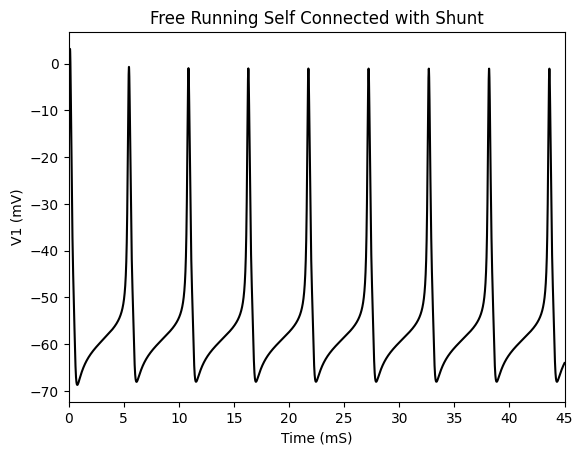

In [42]:
h = 0.001 #h = 0.001#step size for the Runge Kutta Formulation 
tf = 45
N = tf/h
N = int(N)
print(N)
t = np.linspace(0,tf,N+1)


initial_values = [-30.00000, 0.184178, 0.582675, 0.399928, 0.465379, 0.00, 0.00]
sol = ODE_Routine(initial_values,tf,h)

V1 = np.zeros(N+1)
j = 0
for i in range(len(sol)):
    #print('i of rows each time',sol[i][0])
    V1[j] = sol[i][0]
    #print(T[j],V1[j])
    j = j+1
    
itemindex = np.where(V1[:] >= THRESHOLD)
#print(itemindex)

for index in itemindex:
    spike_times = t[index]
    
#print(spike_times)

previous = spike_times[0]
actual_spikes = []
actual_spikes.append(previous)   
for i in range(len(spike_times)):
    if (spike_times[i] - previous > 1 ):
        actual_spikes.append(spike_times[i])
    previous = spike_times[i]

free_running_self = actual_spikes
print('The spike times of a free running neuron are',free_running_self)

difference = []

initial = actual_spikes[0]
for spikes in actual_spikes:
    difference.append(spikes - initial)
    initial = spikes

length_free_hyper = []

for j in range(len(difference)):
    if(j>0):length_free_hyper.append(difference[j])

print(length_free_hyper)

plt.figure()
plt.title('Free Running Self Connected with Shunt')
plt.plot(t,V1, 'k', label='V1')
plt.ylabel('V1 (mV)')
plt.xlabel('Time (mS)')
plt.xlim([0, tf])

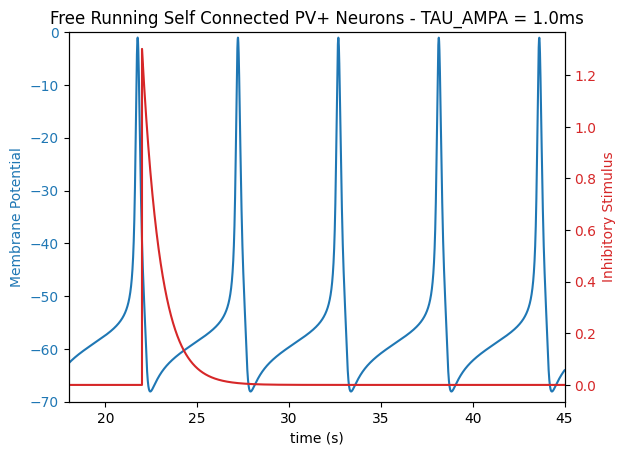

In [43]:
ts = 22
stimulus1 = np.zeros(len(t))
j = 0

for time in t:
    if (time < ts): 
        stimulus1[j] = 0.0
        j = j+1
    else:
        stimulus1[j] = G_SYN_AMPA*(np.exp((ts - time)/TAU_AMPA))
        #print(j,stimulus[j])
        j = j+1



fig, ax1 = plt.subplots()
plt.title('Free Running Self Connected PV+ Neurons - TAU_AMPA = 1.0ms')

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Membrane Potential', color=color)
ax1.plot(t, V1, color=color)
plt.ylim([-70,0])
plt.xlim([18, tf])
ax1.tick_params(axis='y', labelcolor=color)



ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Inhibitory Stimulus', color=color)
ax2.plot(t, stimulus1, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.tick_params(axis='y', labelcolor=color)

#plt.savefig('Free_Self_PV1.eps', format='eps')

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [44]:
def ODE_Routine_Perturb(intitial_values,tf,h,ts):
    e = [spike(initial_values[0],0)]
    h2 = h/2
    N = tf/h
    N = int(N)
    end = int(N)
    t = np.linspace(0,tf,N+1)
    Autapse_Times = []
    t_autapse = -1
    

    #Defining the State, Co-State and Control Variables as Vectors
    V = np.zeros(len(t))
    H = np.zeros(len(t))
    N = np.zeros(len(t))
    A = np.zeros(len(t))
    M = np.zeros(len(t))
    X = np.zeros(len(t))
    G = np.zeros(len(t))

    #Assigning the initial values
    V[0] = initial_values[0]
    H[0] = initial_values[1]
    N[0] = initial_values[2]
    A[0] = initial_values[3]
    M[0] = initial_values[4]
    X[0] = initial_values[5]
    G[0] = initial_values[6]
    
    sol = [initial_values]
    
    for i in range(end):
        if(round(t[i],3) == round(t_autapse,3)):
        #if(t[i] == t_autapse):
            #print(t[i],t_autapse)
            X[i] = X[i] + G_SYN3  
            
        if (t[i] < ts): 
            gsyn1 = 0.0 #Allowing the first three spikes as a freely oscillating neuron 
        else:
            gsyn1 = G_SYN_AMPA*(np.exp((ts - t[i])/TAU_AMPA))

        
        k1V = (I_STIM - I_S2(V[i]) - I_NA(V[i],M[i],H[i]) - I_K1(V[i],A[i]) - I_K3(V[i],N[i]) - I_L(V[i]) - I_S1(V[i],gsyn1) - I_S3(V[i],G[i])) / CM
        k1H = beta(V[i],K1_H,SIGMA1_H)*(1.0 - H[i]) - alpha(V[i],K2_H,THETA_H,SIGMA2_H)*H[i]
        k1N = alpha(V[i],K1_N,THETA_N,SIGMA1_N)*(1.0 - N[i]) - beta(V[i],K2_N,SIGMA2_N)*N[i]
        k1A = alpha(V[i],K1_A,THETA_A,SIGMA1_A)*(1.0 - A[i]) - beta(V[i],K2_A,SIGMA2_A)*A[i]
        k1M = alpha(V[i],K1_M,THETA_M,SIGMA1_M)*(1.0 - M[i]) - beta(V[i],K2_M,SIGMA2_M)*M[i]
        k1X = -X[i]/TAU_TWO
        k1G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * X[i]) - G[i])/TAU_FALL
        
        k2V = (I_STIM - I_S2((V[i]+h2*k1V)) - I_NA((V[i]+h2*k1V),(M[i]+h2*k1M),(H[i]+h2*k1H)) - I_K1((V[i]+h2*k1V),(A[i]+h2*k1A)) - I_K3((V[i]+h2*k1V),(N[i]+h2*k1N)) - I_L((V[i]+h2*k1V)) - I_S1((V[i]+h2*k1V),gsyn1) - I_S3((V[i]+h2*k1V),(G[i]+h2*k1G))) / CM
        k2H = beta((V[i]+h2*k1V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h2*k1H)) - alpha((V[i]+h2*k1V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h2*k1H)
        k2N = alpha((V[i]+h2*k1V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h2*k1N)) - beta((V[i]+h2*k1V),K2_N,SIGMA2_N)*(N[i]+h2*k1N)
        k2A = alpha((V[i]+h2*k1V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h2*k1A)) - beta((V[i]+h2*k1V),K2_A,SIGMA2_A)*(A[i]+h2*k1A)
        k2M = alpha((V[i]+h2*k1V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h2*k1M)) - beta((V[i]+h2*k1V),K2_M,SIGMA2_M)*(M[i]+h2*k1M)
        k2X = -(X[i]+h2*k1X)/TAU_TWO
        k2G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h2*k1X)) - (G[i]+h2*k1G))/TAU_FALL
        
        k3V = (I_STIM - I_S2((V[i]+h2*k2V)) - I_NA((V[i]+h2*k2V),(M[i]+h2*k2M),(H[i]+h2*k2H)) - I_K1((V[i]+h2*k2V),(A[i]+h2*k2A)) - I_K3((V[i]+h2*k2V),(N[i]+h2*k2N)) - I_L((V[i]+h2*k2V)) - I_S1((V[i]+h2*k2V),gsyn1) - I_S3((V[i]+h2*k2V),(G[i]+h2*k2G))) / CM
        k3H = beta((V[i]+h2*k2V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h2*k2H)) - alpha((V[i]+h2*k2V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h2*k2H)
        k3N = alpha((V[i]+h2*k2V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h2*k2N)) - beta((V[i]+h2*k2V),K2_N,SIGMA2_N)*(N[i]+h2*k2N)
        k3A = alpha((V[i]+h2*k2V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h2*k2A)) - beta((V[i]+h2*k2V),K2_A,SIGMA2_A)*(A[i]+h2*k2A)
        k3M = alpha((V[i]+h2*k2V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h2*k2M)) - beta((V[i]+h2*k2V),K2_M,SIGMA2_M)*(M[i]+h2*k2M)
        k3X = -(X[i]+h2*k2X)/TAU_TWO
        k3G = ((((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h2*k2X)) - (G[i]+h2*k2G))/TAU_FALL
        
        k4V = (I_STIM - I_S2((V[i]+h*k3V)) - I_NA((V[i]+h*k3V),(M[i]+h*k3M),(H[i]+h*k3H)) - I_K1((V[i]+h*k3V),(A[i]+h*k3A)) - I_K3((V[i]+h*k3V),(N[i]+h*k3N)) - I_L((V[i]+h*k3V)) - I_S1((V[i]+h*k3V),gsyn1) - I_S3((V[i]+h*k3V),(G[i]+h*k3G))) / CM
        k4H = beta((V[i]+h*k3V),K1_H,SIGMA1_H)*(1.0 - (H[i]+h*k3H)) - alpha((V[i]+h*k3V),K2_H,THETA_H,SIGMA2_H)*(H[i]+h*k3H)
        k4N = alpha((V[i]+h*k3V),K1_N,THETA_N,SIGMA1_N)*(1.0 - (N[i]+h*k3N)) - beta((V[i]+h*k3V),K2_N,SIGMA2_N)*(N[i]+h*k3N)
        k4A = alpha((V[i]+h*k3V),K1_A,THETA_A,SIGMA1_A)*(1.0 - (A[i]+h*k3A)) - beta((V[i]+h*k3V),K2_A,SIGMA2_A)*(A[i]+h*k3A)
        k4M = alpha((V[i]+h*k3V),K1_M,THETA_M,SIGMA1_M)*(1.0 - (M[i]+h*k3M)) - beta((V[i]+h*k3V),K2_M,SIGMA2_M)*(M[i]+h*k3M)
        k4X = -(X[i]+h*k3X)/TAU_TWO
        k4G = ( ( ((TAU_TWO/TAU_FALL) ** (TAU_FALL/(TAU_TWO-TAU_FALL))) * (X[i]+h*k3X)) - (G[i]+h*k3G))/TAU_FALL
        
        V[i+1] = V[i] + (h/6)*(k1V + 2*k2V + 2*k3V + k4V)
        H[i+1] = H[i] + (h/6)*(k1H + 2*k2H + 2*k3H + k4H)
        N[i+1] = N[i] + (h/6)*(k1N + 2*k2N + 2*k3N + k4N)
        A[i+1] = A[i] + (h/6)*(k1A + 2*k2A + 2*k3A + k4A)
        M[i+1] = M[i] + (h/6)*(k1M + 2*k2M + 2*k3M + k4M)
        X[i+1] = X[i] + (h/6)*(k1X + 2*k2X + 2*k3X + k4X)
        G[i+1] = G[i] + (h/6)*(k1G + 2*k2G + 2*k3G + k4G)
        sol+=[[V[i+1], H[i+1], N[i+1], A[i+1],M[i+1],X[i+1],G[i+1]]]
        
        e += [spike(sol[-1],t[-1])]
        if ((e[-1]==1) and (e[-2] == 0)):
            #The neuron has just crossed the threshold
            t_autapse = t[i] + DELAY
            Autapse_Times.append(t_autapse)
            #print('Autapse times',t_autapse)

    #print(i,sol[-1],len(sol))
    return sol


45000
The spike times of a free running neuron are [0.0, 5.3340000000000005, 10.733, 16.165, 21.614, 27.074, 32.538000000000004, 38.007, 43.476]
The spike times of a perturbed neuron are [0.0, 5.3340000000000005, 10.733, 16.165, 21.614, 28.313, 33.956, 39.518]
[5.3340000000000005, 5.399, 5.431999999999999, 5.449000000000002, 6.698999999999998, 5.643000000000004, 5.561999999999998]


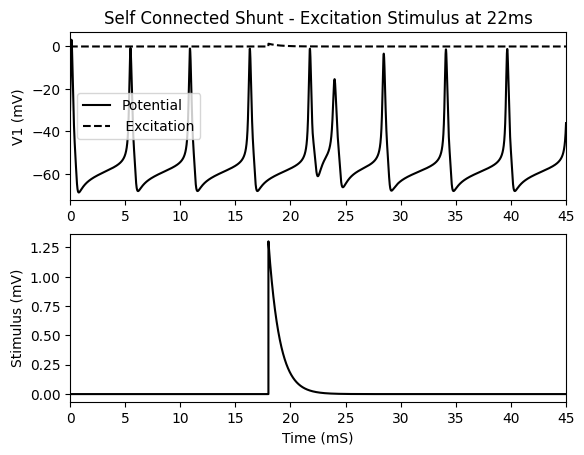

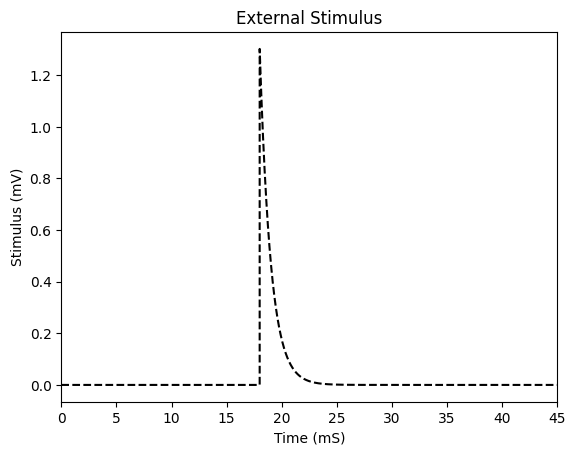

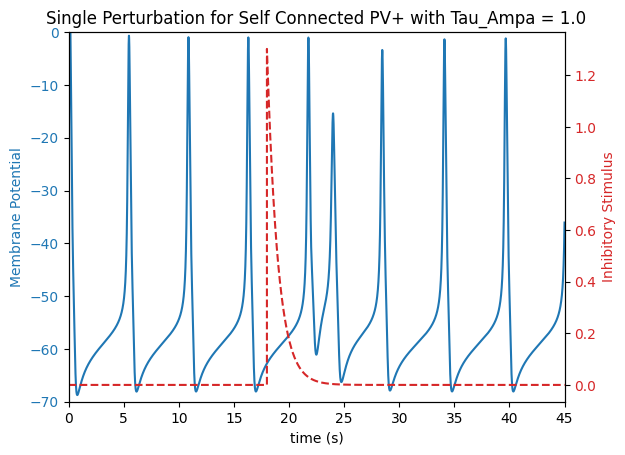

In [45]:
ts = 18
stimulus1 = np.zeros(len(t))
j = 0

for time in t:
    if (time < ts): 
        stimulus1[j] = 0.0
        j = j+1
    else:
        stimulus1[j] = G_SYN_AMPA*(np.exp((ts - time)/TAU_AMPA))
        #print(j,stimulus[j])
        j = j+1


h = 0.001 #h = 0.001#step size for the Runge Kutta Formulation 
tf = 45
N = tf/h
N = int(N)
print(N)
t = np.linspace(0,tf,N+1)
ts = 22

initial_values = [-30.00000, 0.184178, 0.582675, 0.399928, 0.465379, 0.00, 0.00]
sol = ODE_Routine_Perturb(initial_values,tf,h,ts)

V1 = np.zeros(N+1)
k = 0
for i in range(len(sol)):
    #print('i of rows each time',sol[i][0])
    V1[k] = sol[i][0]
    #print(T[j],V1[j])
    k = k+1
    
itemindex = np.where(V1[:] >= THRESHOLD)
#print(itemindex)

for index in itemindex:
    spike_times = t[index]
    
#print(spike_times)

previous = spike_times[0]
actual_spikes = []
actual_spikes.append(previous)   
for i in range(len(spike_times)):
    if (spike_times[i] - previous > 2 ):
        actual_spikes.append(spike_times[i])
    previous = spike_times[i]

single_stimulus_self = actual_spikes
print('The spike times of a free running neuron are',free_running_self)
print('The spike times of a perturbed neuron are',single_stimulus_self)

difference = []

initial = actual_spikes[0]
for spikes in actual_spikes:
    difference.append(spikes - initial)
    initial = spikes

length_free_hyper = []

for j in range(len(difference)):
    if(j>0):length_free_hyper.append(difference[j])

print(length_free_hyper)

plt.figure()
plt.subplot(2,1,1)
plt.title('Self Connected Shunt - Excitation Stimulus at 22ms')
plt.plot(t,V1, 'k', label='Potential')
plt.plot(t,stimulus1, 'k--', label=' Excitation')
plt.legend()
plt.ylabel('V1 (mV)')
#plt.xlabel('Time (mS)')
#plt.xlim([0, tf])
plt.xlim([0, tf])

#plt.title('External Stimulus')
plt.subplot(2,1,2)
plt.plot(t,stimulus1, 'k', label=' Excitation')
plt.ylabel('Stimulus (mV)')
plt.xlabel('Time (mS)')
plt.xlim([0, tf])

plt.figure()
plt.title('External Stimulus')
plt.plot(t,stimulus1, 'k--', label=' Excitation')
plt.ylabel('Stimulus (mV)')
plt.xlabel('Time (mS)')
plt.xlim([0, tf])

fig, ax1 = plt.subplots()
plt.title('Single Perturbation for Self Connected PV+ with Tau_Ampa = 1.0')

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Membrane Potential', color=color)
ax1.plot(t, V1, color=color)
plt.ylim([-70,0])
plt.xlim([0, tf])
ax1.tick_params(axis='y', labelcolor=color)



ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_xlabel('time (s)')
ax2.set_ylabel('Inhibitory Stimulus', color=color)
ax2.plot(t, stimulus1,'--' , color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.tick_params(axis='y', labelcolor=color)

#plt.savefig('Single_Perturb_Self_PV1.eps', format='eps')

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [46]:
T1 = free_running_self[4]
T2 = free_running_self[5]
T3 = free_running_self[6]
period_free = T2-T1
epsilon = 0.01
#prc_interval = np.arange(T1+epsilon, T2-epsilon, epsilon)
prc_interval = np.linspace(T1+epsilon, T2, 100)
stim_interval = prc_interval-T1
phase = stim_interval/period_free

prc_readings1 = np.zeros((len(prc_interval),3))

ts = T1 + epsilon
j=0
for ts in prc_interval:
    h = 0.001 #h = 0.001#step size for the Runge Kutta Formulation 
    tf = 50
    N = tf/h
    N = int(N)
    #print(N)
    t = np.linspace(0,tf,N+1)
    
    initial_values = [-30.00000, 0.184178, 0.582675, 0.399928, 0.465379, 0.00, 0.00]
    sol = ODE_Routine_Perturb(initial_values,tf,h,ts)

    V1 = np.zeros(N+1)

    k = 0
    for i in range(len(sol)):
        #print('i of rows each time',sol[i][0])
        V1[k] = sol[i][0]
        k = k+1
    
    itemindex = np.where(V1[:] > THRESHOLD)
    
    for index in itemindex:
        spike_times = t[index]
        
    previous = spike_times[0]
    actual_spikes = []
    actual_spikes.append(previous)   
    for i in range(len(spike_times)):
        if (spike_times[i] - previous > 1 ):
            actual_spikes.append(spike_times[i])
        previous = spike_times[i]
    #print(j,ts,actual_spikes)
    diff_timings = np.zeros(len(free_running_self))
    for p in range(len(free_running_self) - 1):
        diff_timings[p] = actual_spikes[p+1] - actual_spikes[p] - period_free
    #print(diff_timings,diff_timings.shape)

    
    print(phase[j],diff_timings[4:7]/period_free)
    #prc_readings.append(diff_timings)
    prc_readings1[j,:] = diff_timings[4:7]/period_free
    j = j+1



0.0018315018315021175 [-0.57893773 -0.0978022   0.03333333]
0.011914011914012354 [-0.58131868 -0.10934066  0.03333333]
0.02199652199652259 [-0.58388278 -0.12124542  0.03369963]


KeyboardInterrupt: 

(0.0, 1.0)

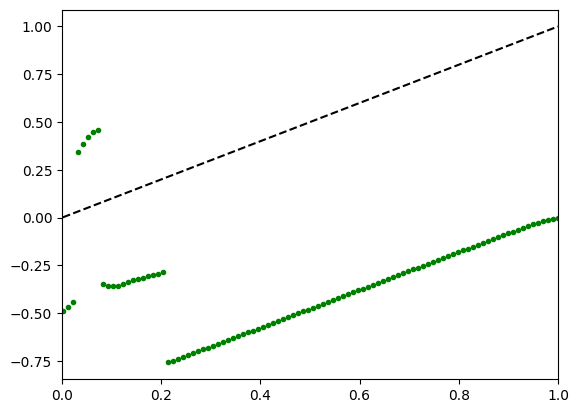

In [36]:
#print('The final readings required for the PRC are:',prc_readings1)
#print(prc_readings1.shape)
#print(phase.shape)

fig = plt.figure()
ax = fig.add_subplot()

#plt.title('PRCs for Self Connected Inhibitory Neuron with Excitation - Shunt')
plt.plot(phase, prc_readings1[:,0], 'g.', label='1st Order')
plt.plot(phase, phase, 'k--')
#plt.plot(phase, prc_readings1[:,1], 'r', label='2nd Order')
#plt.plot(phase, prc_readings[:,2], 'g', label='2nd Order')
#plt.ylabel('Phase Resetting')
#plt.xlabel('Phase')
ax.set_axisbelow(True)
#plt.legend()

#plt.savefig('PRC_EtoI1.eps', format='eps')

# Turn on the minor TICKS, which are required for the minor GRID

plt.xlim([0, 1])
#plt.savefig('PRC_SC2Cluster_1017.eps', format='eps')

In [37]:
output = np.zeros((len(prc_interval),2))
output[:,0] = phase
output[:,1] = prc_readings1[:,0]
df = pd.DataFrame(output, columns=['Phase', 'First_Order'])
df.to_excel('PRC_SC2PVCluster_1107.xlsx', sheet_name='SC2PVCluster')